In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install aiohttp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.7 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn import metrics
import nest_asyncio
import pandas as pd
import numpy as np
import itertools
import aiohttp
import asyncio
import os.path
import string
import nltk

In [ ]:
nest_asyncio.apply()
path = '/content/gdrive/MyDrive/MLProject-humanVsmachine/bot.csv'




In [ ]:
async def get_bot_stories():
    async with aiohttp.ClientSession() as session:
        for number in range(1, 1000):
            story_url = "https://boredhumans.com/api_story.php"
            async with session.post(story_url) as resp:
                story = await resp.text()
                bot_st_file.write(str(number))
                bot_st_file.write('|')
                bot_st_file.write(story.replace('\n',''))
                bot_st_file.write('\n')

if(os.path.isfile(path) == False):
    bot_st_file = open(path,'a')
    loop = asyncio.get_event_loop()
    loop.run_until_complete(get_bot_stories())


In [ ]:
#df = pd.read_csv('filename', encoding='utf-8')
#lineterminator='\n',sep='|', names=['bookno','content']
import io
df_bot = pd.read_csv('/content/gdrive/MyDrive/MLProject-humanVsmachine/bot_stories.csv', encoding='utf-8',header=None, sep='|',names=['bookno','content'])

df_bot.drop_duplicates(inplace=True)
df_bot['human'] = False
df_bot.head()


,bookno,content,human
0,1,I'm not in the business of trying to explain w...,False
1,2,"Just a friend, a friend. I was about to leave ...",False
2,1,i was sitting in my parents' little house at t...,False
3,2,"I was very nervous that I would be killed, bec...",False
4,3,I don't know anybody who had to put in the wor...,False


In [ ]:
df_human = pd.read_csv('/content/gdrive/MyDrive/MLProject-humanVsmachine/stories.csv')
df_human['human'] = True
df_human.head()

,bookno,content,human
0,51082.txt,*** START OF THIS PROJECT GUTENBERG EBOOK COMI...,True
1,32243.txt,*** START OF THIS PROJECT GUTENBERG EBOOK CONF...,True
2,306-0.txt,*** START OF THIS PROJECT GUTENBERG EBOOK EARL...,True
3,31038.txt,*** START OF THIS PROJECT GUTENBERG EBOOK THE ...,True
4,28636-8.txt,*** START OF THIS PROJECT GUTENBERG EBOOK THE ...,True


In [ ]:
start_intro = 'start of this project gutenberg ebook '
end_intro = ', by fritz leiber'.lower()
df_human.head()

,bookno,content,human
0,51082.txt,*** START OF THIS PROJECT GUTENBERG EBOOK COMI...,True
1,32243.txt,*** START OF THIS PROJECT GUTENBERG EBOOK CONF...,True
2,306-0.txt,*** START OF THIS PROJECT GUTENBERG EBOOK EARL...,True
3,31038.txt,*** START OF THIS PROJECT GUTENBERG EBOOK THE ...,True
4,28636-8.txt,*** START OF THIS PROJECT GUTENBERG EBOOK THE ...,True


In [ ]:
data = pd.concat( [df_bot, df_human])
data = shuffle( data )
data = data.reset_index( drop=True )
data.drop(["bookno"],axis=1,inplace=True)
data.drop_duplicates(subset=['content'])
data.dropna()
data.describe()

,content,human
count,2003,2003
unique,1846,2
top,"in the middle of the early 2000s, an oil spill...",True
freq,5,1002


In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')

data['content'] = data['content'].apply(lambda x: x.lower())
data['content'] = data['content'].str.replace('[{}]'.format(string.punctuation), '')
data['content'] = data['content'].str.replace('\n','')
data['content'] = data['content'].str.replace(start_intro,'')
data['content'] = data['content'].str.replace(end_intro, '')
data['content'] = data['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-13-816e78994cd6>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['content'] = data['content'].str.replace('[{}]'.format(string.punctuation), '')


,content,human
0,last crusade produced greg weeks mary meehan o...,True
1,sandman’s hour produced al hainesillustration ...,True
2,im saying know wont win certainly make things ...,False
3,im man gotten accident day get kids school nex...,False
4,trying tell average story like actor saying oh...,False


In [ ]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data['content'], data.human, test_size=0.3, random_state=42)

In [ ]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
# Fitting the model
model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


accuracy: 99.0%


Confusion matrix, without normalization


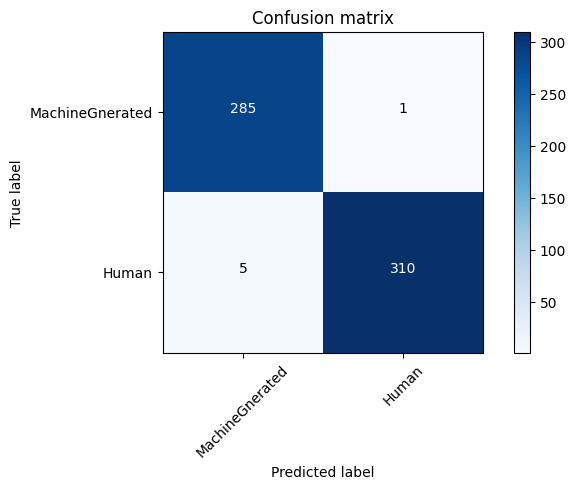

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['MachineGnerated', 'Human'])

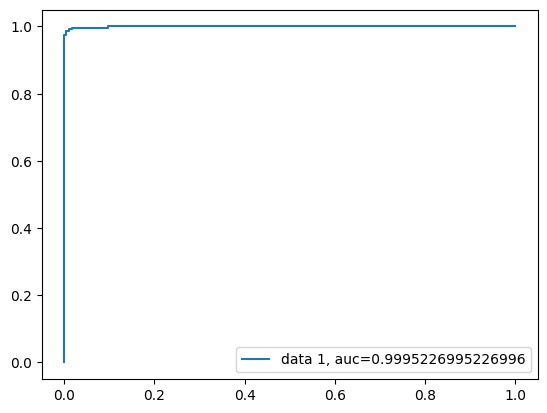

In [ ]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
df_gpt3 = pd.read_csv('/content/gdrive/MyDrive/MLProject-humanVsmachine/gpt-3.txt', header=None, sep='|', names=['bookno','content'])
df_gpt3.drop(["bookno"],axis=1,inplace=True)
df_gpt3['content'] = df_gpt3['content'].apply(lambda x: x.lower())
df_gpt3['content'] = df_gpt3['content'].str.replace('[{}]'.format(string.punctuation), '')
df_gpt3['content'] = df_gpt3['content'].str.replace('\n','')
df_gpt3['content'] = df_gpt3['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_gpt3.head()

<ipython-input-19-f6a178ae423d>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_gpt3['content'] = df_gpt3['content'].str.replace('[{}]'.format(string.punctuation), '')


,content
0,human robot thinking robot use 012 cognitive c...
1,captain captain fearful trip done ship weather...
2,flanders fields poppies blow crosses row row m...


In [ ]:
y_pred_gpt = model.predict(df_gpt3['content'])
y_pred_gpt

array([ True,  True, False])

In [ ]:
print("accuracy: {}%".format(round(accuracy_score(df_gpt3, y_pred_gpt)*100,2)))

accuracy: 0.0%


In [ ]:
#Showing confusion Matrix and precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Micro Precision: {:.2f}'.format(precision_score(y_test, prediction, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, prediction, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, prediction, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, prediction, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, prediction, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, prediction, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, prediction, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, prediction, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, prediction, average='weighted')))

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.99
Macro Recall: 0.99
Macro F1-score: 0.99

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99


In [ ]:
model.data['content'].value_counts().plot(kind="bar")
plt.title("Prediction counts of the target variable of test data")
plt.xlabel("Human Vs Machine generated")
plt.xticks(rotation=0)
plt.ylabel("Count")
plt.show()

AttributeError: ignored

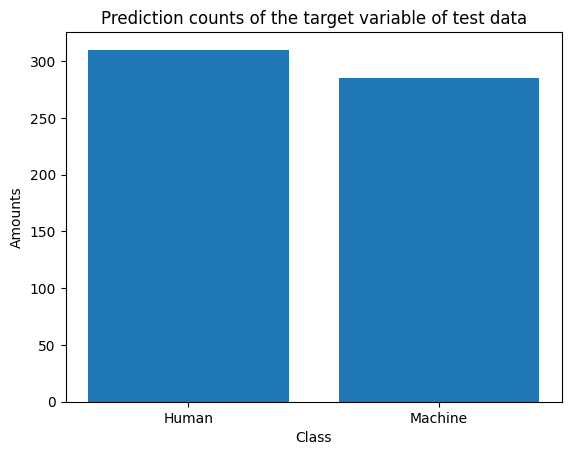

In [ ]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

data = [310,285]
labels = ['Human', 'Machine']
plt.xticks(range(len(data)), labels)
plt.xlabel('Class')
plt.ylabel('Amounts')
plt.title('Prediction counts of the target variable of test data')
plt.bar(range(len(data)), data)
plt.show()